## Intro

In [ ]:
from google.colab import drive 
drive.mount("/content/gdrive")

Drive already mounted at /content/gdrive; to attempt to forcibly remount, call drive.mount("/content/gdrive", force_remount=True).


In [ ]:
#clean memory
import gc
try:
    del images
except:
    pass
gc.collect(2)

976

### File Paths

In [ ]:
image_path = "/content/gdrive/My Drive/Inverse Problems/Images/"
model_path = "/content/gdrive/My Drive/Inverse Problems/Models/"
history_path = "/content/gdrive/My Drive/Inverse Problems/CSV/"
graph_path = "/content/gdrive/My Drive/Inverse Problems/Graphs/"

In [ ]:
from keras.layers import Input, Dense
from keras.models import Model
from keras import regularizers
from keras.layers import Input, Dense, Conv2D, MaxPooling2D, UpSampling2D
from keras.models import Model
from keras import backend as K
import matplotlib.pyplot as plt

In [ ]:
from skimage.metrics import peak_signal_noise_ratio
from scipy.ndimage import gaussian_filter
from numpy import savetxt
from numpy import loadtxt
import os 
import pandas as pd

In [ ]:
from keras.datasets import mnist, fashion_mnist
import numpy as np
data_dict = {"mnist": mnist.load_data(), "fashion_mnist": fashion_mnist.load_data()}

## Data Set 

In [ ]:
(x_train, _), (x_test, _) = mnist.load_data()

x_train = x_train.astype('float32') / 255.
x_test = x_test.astype('float32') / 255.
x_train = np.reshape(x_train, (len(x_train), 28, 28, 1))  # adapt this if using `channels_first` image data format
x_test = np.reshape(x_test, (len(x_test), 28, 28, 1))  # adapt this if using `channels_first` image data format

### Function to add noise/blur

In [ ]:
#Make noisy images 

def add_noise(x,y,delta):
    x = x + delta * np.random.normal(loc=0.0, scale=1.0, size=x_train.shape) 
    y = y + delta * np.random.normal(loc=0.0, scale=1.0, size=x_test.shape) 

    x = np.clip(x, 0., 1.)
    y = np.clip(y, 0., 1.)

    return x,y

In [ ]:
#Make blurry images  

def add_blur_noise(x,y,delta):
    x = gaussian_filter(x_train, sigma=0.5) + delta * np.random.normal(loc=0.0, scale=1.0, size=x_train.shape) 
    y = gaussian_filter(x_test, sigma=0.5)   + delta * np.random.normal(loc=0.0, scale=1.0, size=x_test.shape) 
    x = np.clip(x, 0., 1.)
    y = np.clip(y, 0., 1.)

    return x,y

### Function to calulate average PSNR

In [ ]:
def calculate_psnr(u, u_rec, n):
    psnr_vec = np.zeros(n)
    for i in range(0,n): 
        psnr_vec[i] = peak_signal_noise_ratio(u[i].reshape(28,28), u_rec[i].reshape(28,28))
    
    mean = round(np.mean(psnr_vec),2)
    return mean 

### Function to Plot Loss

In [ ]:
def plot_loss(history_dic):
    iterations = list(range(1,len(history_dic['loss'])+1))
    plt.plot(iterations,history_dic['loss'],label='training')
    plt.plot(iterations,history_dic['val_loss'],label='validation')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.legend()
    plt.savefig(graph_path+'loss.png')
    plt.show()

### Plot

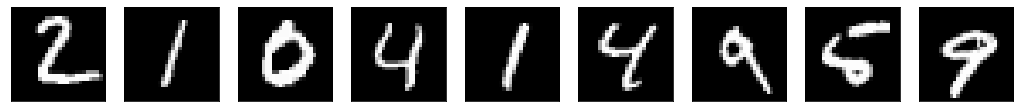

In [ ]:
#show orginal images 
n = 10
plt.figure(figsize=(20, 2))
for i in range(1, n):
    ax = plt.subplot(1, n, i)
    plt.imshow(x_test[i].reshape(28, 28))
    plt.gray()
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)
plt.show()

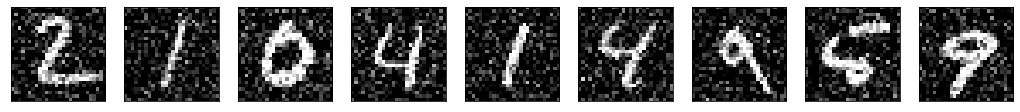

In [ ]:
#show noisy images
x_train_noisy, x_test_noisy = add_noise(x_train,x_test,0.25)

n = 10
plt.figure(figsize=(20, 2))
for i in range(1, n):
    ax = plt.subplot(1, n, i)
    plt.imshow(x_test_noisy[i].reshape(28, 28))
    plt.gray()
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)
plt.show()

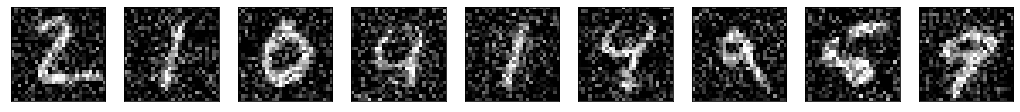

In [ ]:
#show blurry + noisy images
x_train_blurry, x_test_blurry = add_blur_noise(x_train,x_test,0.25)

n = 10
plt.figure(figsize=(20, 2))
for i in range(1, n):
    ax = plt.subplot(1, n, i)
    plt.imshow(x_test_blurry[i].reshape(28, 28))
    plt.gray()
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)
plt.show()

##Noise Levels

In [ ]:
noise_levels_dic = {'0.1':0.10, '0.2':0.2, '0.3':0.30, '0.4':0.4, 
                    '0.5': 0.50, '0.6':0.60, '0.7':0.7,'0.8':0.8,
                    '0.9':0.9, '1':1
                    }
epochs=1
psnr_dic={} 

## Autodenoising with CNN

### The Model

In [ ]:
#The model
input_img = Input(shape=(28, 28, 1))  # adapt this if using `channels_first` image data format

x = Conv2D(32, (3, 3), activation='relu', padding='same')(input_img)
x = MaxPooling2D((2, 2), padding='same')(x)
x = Conv2D(32, (3, 3), activation='relu', padding='same')(x)
encoded = MaxPooling2D((2, 2), padding='same')(x)

# at this point the representation is (7, 7, 32)

x = Conv2D(32, (3, 3), activation='relu', padding='same')(encoded)
x = UpSampling2D((2, 2))(x)
x = Conv2D(32, (3, 3), activation='relu', padding='same')(x)
x = UpSampling2D((2, 2))(x)
decoded = Conv2D(1, (3, 3), activation='sigmoid', padding='same')(x)

autoencoder = Model(input_img, decoded)

#compile model 
autoencoder.compile(optimizer='adadelta', loss='binary_crossentropy')

NameError: ignored

### Training for Noisy data

In [ ]:
for noise_level, delta in noise_levels_dic.items():
    #make data 
    x_train_noisy, x_test_noisy = add_noise(x_train,x_test,delta)
    save_name = "_".join(('noise_level ',noise_level))
    #fit the model
    print('\n')
    print('\n')
    print('Fitting model on data with noise level '+noise_level)
    print('\n')
    history = autoencoder.fit(x_train_noisy, x_train,
                    epochs=epochs,
                    batch_size=128,
                    shuffle=True,
                    validation_data=(x_test_noisy, x_test))
    
    #Saves in a record of the training and validation loss
    pd.DataFrame(history.history).to_csv(history_path+save_name+".csv")

    autoencoder.save(model_path+save_name+".h5")

    #evalute the model 
    print('\n')
    print('Evaluating Model')
    print('\n')
    accuracy_train = history.model.evaluate(x_train_noisy,x_train,verbose=0)
    accuracy_test = history.model.evaluate(x_test_noisy,x_test, verbose=0)

    
    plot_loss(history.history)

    #plot
    # encode and decode some digits
    # note that we take them from the *test* set
    print('Plotting')
    print('\n')
    encoded_imgs = autoencoder.predict(x_test_noisy[:100])
    decoded_imgs = autoencoder.predict(encoded_imgs)

    n = 10  # how many digits we will display
    plt.figure(figsize=(20, 4))
    for i in range(1, n):
        # display original noisy
        ax = plt.subplot(2, n, i+1)
        plt.imshow(x_test_noisy[i].reshape(28, 28))
        plt.gray()
        ax.get_xaxis().set_visible(False)
        ax.get_yaxis().set_visible(False)
        

        # display reconstruction
        ax = plt.subplot(2, n, i + 1 + n)
        plt.imshow(decoded_imgs[i].reshape(28, 28))
        plt.gray()
        ax.get_xaxis().set_visible(False)
        ax.get_yaxis().set_visible(False)

    plt.savefig(image_path+
                save_name+'.png', bbox_inches='tight')
    plt.show()

    #calculate PSNR based on 5000 samples and saves in dictionary
    psnr_dic[noise_level]=calculate_psnr(x_test,x_test_noisy,5000)


# saves to csv file
pd.DataFrame(psnr_dic,index=psnr_dic.keys()).to_csv(history_path+"psnr_noise.csv")





Fitting model on data with noise level 0.1


Epoch 1/2
469/469 [==============================] - 131s 278ms/step - loss: 0.7078 - val_loss: 0.6969
Epoch 2/2
292/469 [=================>............] - ETA: 47s - loss: 0.6944

KeyboardInterrupt: ignored

### Fit for blurry + noisy data

In [ ]:
for noise_level, delta in noise_levels_dic.items():
    #make data 
    x_train_noisy, x_test_noisy = add_blur_noise(x_train,x_test,delta)
    save_name = "_".join(('blur_level_0.5_with_noise_level ',noise_level))
    #fit the model
    print('\n')
    print('\n')
    print('Fitting model on data with noise level '+noise_level)
    print('\n')
    history = autoencoder.fit(x_train_noisy, x_train,
                    epochs=epochs,
                    batch_size=128,
                    shuffle=True,
                    validation_data=(x_test_noisy, x_test))
    
    #Saves in a record of the training and validation loss
    pd.DataFrame(history.history).to_csv(history_path+save_name+".csv")

    autoencoder.save(model_path+save_name+".h5")

    #evalute the model 
    print('\n')
    print('Evaluating Model')
    print('\n')
    accuracy_train = history.model.evaluate(x_train_noisy,x_train,verbose=0)
    accuracy_test = history.model.evaluate(x_test_noisy,x_test, verbose=0)

    
    plot_loss(history.history)

    #plot
    # encode and decode some digits
    # note that we take them from the *test* set
    print('Plotting')
    print('\n')
    encoded_imgs = autoencoder.predict(x_test_noisy[:100])
    decoded_imgs = autoencoder.predict(encoded_imgs)

    n = 10  # how many digits we will display
    plt.figure(figsize=(20, 4))
    for i in range(1, n):
        # display original noisy
        ax = plt.subplot(2, n, i+1)
        plt.imshow(x_test_noisy[i].reshape(28, 28))
        plt.gray()
        ax.get_xaxis().set_visible(False)
        ax.get_yaxis().set_visible(False)
        

        # display reconstruction
        ax = plt.subplot(2, n, i + 1 + n)
        plt.imshow(decoded_imgs[i].reshape(28, 28))
        plt.gray()
        ax.get_xaxis().set_visible(False)
        ax.get_yaxis().set_visible(False)

    plt.savefig(image_path+
                save_name+'.png', bbox_inches='tight')
    plt.show()

    #calculate PSNR based on 5000 samples and saves in dictionary
    psnr_dic[noise_level]=calculate_psnr(x_test,x_test_noisy,5000)


# saves to csv file
pd.DataFrame(psnr_dic,index=psnr_dic.keys()).to_csv(history_path+"psnr_blur.csv")

## Comparison for noisy data

In [ ]:
# diffusion operator
def L(u,coeff = lambda s : 1):
    ue = np.pad(u,1,mode='edge') # padd edges to get array of size n+2 x n+2

    # diffusion coefficient (central differences)
    grad_norm = ((ue[2:,1:-1] - ue[:-2,1:-1])/(2/n))**2 + ((ue[1:-1,2:] - ue[1:-1,:-2])/(2/n))**2
    c = np.pad(coeff(grad_norm),1,mode='edge')

    # diffusion term (combination of forward and backward differences)
    uxx = ((c[1:-1,1:-1] + c[2:,1:-1])*(ue[2:,1:-1]-ue[1:-1,1:-1]) - (c[:-2,1:-1]+c[1:-1,1:-1])*(ue[1:-1,1:-1]-ue[:-2,1:-1]))/(2/n**2)
    uyy = ((c[1:-1,1:-1] + c[1:-1,2:])*(ue[1:-1,2:]-ue[1:-1,1:-1]) - (c[1:-1,:-2]+c[1:-1,1:-1])*(ue[1:-1,1:-1]-ue[1:-1,:-2,]))/(2/n**2)

    return uxx + uyy

In [ ]:
noise_levels_dic = {'0.1':0.10, '0.2':0.20, '0.3':0.30, 
                    '0.4':0.40, '0.5':0.50, '0.6':0.60, 
                    '0.7':0.70, '0.8':0.80, '0.9':0.90, '1':1}

### Perona-Malik and ROF TV regularisation 

In [ ]:
# parameters
alpha = 10
dt = 1e-6
niter = 1001
n = 28
# coeff = lambda s : 1/(1+1e6*s)

# #coeff for tv
# coeff = lambda s : 1/((5)+np.sqrt(s))

In [ ]:
heat_method_dic={'Perona_Malik':lambda s : 1/(1+1e6*s), 
                  'ROF_TV': lambda s : 1/((5)+np.sqrt(s))}

psnr_per_method_dic={}

In [ ]:
def plot_reconstruction(data, n):

    fig = plt.figure(figsize=(20, 4), dpi=300)
    fig.tight_layout()
    
    for i in range(n):
        item = data[i]
        
        # display original noisy
        ax = plt.subplot(2, n, i+1)
        plt.imshow(item[0, :, :])
        plt.gray()
        ax.get_xaxis().set_visible(False)
        ax.get_yaxis().set_visible(False)


        # display reconstruction
        ax = plt.subplot(2, n, i + 1 + n)
        plt.imshow(item[1, :, :])
        plt.gray()
        ax.get_xaxis().set_visible(False)
        ax.get_yaxis().set_visible(False)
        
    plt.show()

In [ ]:
from skimage.metrics import structural_similarity as ssim
from skimage import img_as_float
from skimage.restoration import denoise_tv_chambolle

#sample size
sample_size = 2
psnr_vec = np.zeros(sample_size)
mean_psnr_dic = {}
mean_psnr_per_method_dic = {}
psnr_dic = {}
psnr_per_method_dic = {}

ssim_vec = {}
ssim_dic = {}
ssim_per_method_dic = {}

# for noise_level, delta in noise_levels_dic.items():
#     print('Noise level : ', noise_level)
for method, coeff in heat_method_dic.items():
    print('Method : ', method)
    datas = np.zeros((sample_size, 2, 28, 28))
    psnr_vec = np.zeros(sample_size)

    for noise_level, delta in noise_levels_dic.items():
        print('Noise level : ', noise_level)
    
        
        for i in range(0, sample_size):
            f = img_as_float(x_train[i].reshape(28,28))
            f_delta = f + np.random.normal(loc=0.0, scale=delta, size=f.shape)
            f_delta = np.clip(f_delta, 0, 1)
            # solve evolution equation
            u = np.zeros((n,n))

            # (image, weight=0.1, eps=0.0002, n_iter_max=200, multichannel=False, *, channel_axis=None)
            #for ROF couldn't find one where Perona-Malik worked
            u = denoise_tv_chambolle(f_delta, weight=alpha, eps=0.0002, n_iter_max=niter-1)
            # for k in range(niter-1):
            #     u = u - dt*(u - alpha*L(u,coeff)) + dt*f_delta
 
            # u = img_as_float(u)
            psnr_vec[i] = peak_signal_noise_ratio(x_train[i].reshape(28,28),u)
            ssim_vec[i] = ssim(f, u, data_range=1)

            # Samples to display
            if i < 10:
                datas[i][0] = f_delta
                datas[i][1] = u
        
        psnr_dic[noise_level] = psnr_vec.copy()
        psnr_per_method_dic[method] = psnr_dic.copy()
        
        ssim_dic[noise_level] = ssim_vec.copy()
        ssim_per_method_dic[method] = ssim_dic.copy()
        
        mean_psnr_dic[noise_level] = round(np.mean(psnr_vec), 2)
        mean_psnr_per_method_dic[method] = mean_psnr_dic.copy()

        # plot_reconstruction(datas, 10)

In [ ]:
 psnr_per_method_dic

In [ ]:
def box_plot_psnr(data, title, labels):
    fig, ax = plt.subplots(dpi=300)
    ax.set_title(title)
    ax.set_xlabel(r'Noise $\sigma$')
    ax.set_ylabel('PSNR')
    ax.boxplot(data, labels=labels)
    plt.show()
    
box_plot_psnr(psnr_per_method_dic['Perona_Malik'].values(), 'Perona-Malik', noise_levels_dic.keys())
box_plot_psnr(psnr_per_method_dic['ROF_TV'].values(), 'Total Variation', noise_levels_dic.keys())

###Some thing wrong with the PSNR

In [ ]:
# import numpy as np
# import matplotlib.pyplot as plt

# from skimage import data
# from skimage.util import random_noise
# from skimage.transform import resize

# # parameters
# sigma = 0.1
# alpha = 1
# dt = 1e-6
# niter = 1001
# n = 28
# coeff = lambda s : 1/(1+1e6*s)

# # diffusion operator
# def L(u,coeff = lambda s : 1):
#     ue = np.pad(u,1,mode='edge') # padd edges to get array of size n+2 x n+2

#     # diffusion coefficient (central differences)
#     grad_norm = ((ue[2:,1:-1] - ue[:-2,1:-1])/(2/n))**2 + ((ue[1:-1,2:] - ue[1:-1,:-2])/(2/n))**2
#     c = np.pad(coeff(grad_norm),1,mode='edge')

#     # diffusion term (combination of forward and backward differences)
#     uxx = ((c[1:-1,1:-1] + c[2:,1:-1])*(ue[2:,1:-1]-ue[1:-1,1:-1]) - (c[:-2,1:-1]+c[1:-1,1:-1])*(ue[1:-1,1:-1]-ue[:-2,1:-1]))/(2/n**2)
#     uyy = ((c[1:-1,1:-1] + c[1:-1,2:])*(ue[1:-1,2:]-ue[1:-1,1:-1]) - (c[1:-1,:-2]+c[1:-1,1:-1])*(ue[1:-1,1:-1]-ue[1:-1,:-2,]))/(2/n**2)

#     return uxx + uyy

# # noisy image
# idx = np.random.randint(0,x_train.shape[0],2)

# sigma=[0.1,0.5,1]
# for s in sigma:
#     print(s)
#     for i in idx: 
#         f = img_as_float(x_train[i].reshape(28,28))
#         f_delta = f + np.random.normal(loc=0.0, scale=s, size=f.shape)
#         f_delta = np.clip(f_delta, 0, 1)

#         # solve evolution equation
#         # u = np.zeros((n,n))

#         for k in range(niter-1):
#             u = u - dt*(u - alpha*L(u,coeff)) + dt*f_delta

#         


#         print(peak_signal_noise_ratio(f,u)) 


### Plot some samples 

In [ ]:
# ax[0].imshow(f_delta)
# ax[0].set_title('Noisy image')
# ax[0].set_xticks([])
# ax[0].set_yticks([])

# ax[1].imshow(u_tv)
# ax[1].set_title('Result NonLin TV')
# ax[1].set_xticks([])
# ax[1].set_yticks([])

## Comparison for blurry + noisy images

In [ ]:
# # grid \Omega = [0,1]
# n = 784
# h = 1/(n-1)
# x = np.linspace(0,1,n)

# # parameters
# niter = 10000
# lmbda = 1


# #Compute the D
# def compute_D(u):
#     D_xy = np.gradient(u.reshape(28,28))
#     D_x  = D_xy[0]
#     D_y  = D_xy[1]
#     D = np.sqrt(np.abs(D_x)**2+ np.abs(D_y)**2)
#     D=D.flatten()
#     D=np.diag(-D) + np.diag(D[:-1],1)

#     return D

### Proximal Gradient Descent - Failed

In [ ]:
# def prox_grad(f,lmbda,D,alpha,niter):
#     nu = np.zeros(D.shape[0])
#     hist = np.zeros((niter,2))

#     P = lambda nu : np.piecewise(nu, [np.abs(nu) <= lmbda, np.abs(nu) > lmbda], 
#                                  [lambda x : x, lambda x : lmbda*np.sign(x)])

#     for k in range(0,niter):
#         nu = P(nu - alpha*D@(D.T@nu - f))
#         u = f - D.T@nu
#         # primal = 0.5*np.linalg.norm(u - f)**2 + lmbda*np.linalg.norm(D@u,ord=1)
#         # dual = -0.5*np.linalg.norm(D.T@nu) + f.dot(D.T@nu)
#         # hist[k] = primal, dual

#     return u


In [ ]:
# sample_size = 5
# psnr_vec = np.zeros(sample_size)
# mean_psnr_dic={}

# for noise_level, delta in noise_levels_dic.items():
#     save_name = "_".join(('blur_level_0.5_with_noise_level ',noise_level))
#     for i in range(0,sample_size):
#         f = x_train[i].reshape(28,28).flatten()
#         f_delta = gaussian_filter(x_train[i], sigma=0.5) + delta * np.random.normal(loc=0.0, scale=1.0, size=x_train[i].shape)
#         D = compute_D(f_delta)
#         # proximal gradient on dual problem
#         alpha = 1/np.linalg.norm(D)**2
#         u_prox = prox_grad(f_delta.flatten(),lmbda,D,alpha,niter)
#         psnr_vec[i]=peak_signal_noise_ratio(f,f_delta)
#     mean_psnr_dic[noise_level]=np.mean(psnr_vec) 

### Plot some sample 

In [ ]:
# # plot
# fig,ax = plt.subplots(1,2)

# plt.gray()

# ax[0].imshow(f_delta.reshape(28,28))
# ax[0].set_title('Noisy image')
# ax[0].set_xticks([])
# ax[0].set_yticks([])

# ax[1].imshow(u_prox.reshape(28,28))
# ax[1].set_title('Result Prox')
# ax[1].set_xticks([])
# ax[1].set_yticks([])

### Admm - Failed

In [ ]:
# def admm(f,lmbda,D,rho,niter):
#     m,n = D.shape
#     nu = np.zeros(m)
#     v = np.zeros(m)
#     u = np.zeros(n)
#     hist = np.zeros((niter,2))

#     T = lambda v : np.piecewise(v, [v < -lmbda/rho, np.abs(v) <= lmbda/rho, v > lmbda/rho], 
#                                 [lambda x : x + lmbda/rho, lambda x : 0, lambda x : x - lmbda/rho])

#     for k in range(0,niter):
#         u = np.linalg.solve(np.eye(n) + rho*D.T@D, f + D.T@(rho*v - nu))
#         v = T(D@u + nu/rho)
#         nu = nu + rho*(D@u - v)

#         # primal = 0.5*np.linalg.norm(u - f)**2 + lmbda*np.linalg.norm(D@u,ord=1)
#         # dual = -0.5*np.linalg.norm(D.T@nu) + f.dot(D.T@nu)
#         # hist[k] = primal, dual

#     return u

In [ ]:
# ADMM
#generate some data
# delta = 0
# idx=5
# f_delta = gaussian_filter(x_train[idx], sigma=0.5) + delta * np.random.normal(loc=0.0, scale=1.0, size=x_train[idx].shape)

# D = compute_D(f_delta)

# rho = 1
# lmbda = 1
# u_admm = admm(f_delta.flatten(),lmbda,D,rho,niter)

In [ ]:
# # plot
# fig,ax = plt.subplots(1,2)

# plt.gray()

# ax[0].imshow(f_delta.reshape(28,28))
# ax[0].set_title('Blurred image')
# ax[0].set_xticks([])
# ax[0].set_yticks([])

# ax[1].imshow(u_admm.reshape(28,28))
# ax[1].set_title('Result ADMM')
# ax[1].set_xticks([])
# ax[1].set_yticks([])

# peak_signal_noise_ratio(x_train[idx].reshape(28,28),u_admm.reshape(28,28))

# #result 16

## ProxImaL lib

In [ ]:
pip install proximal

In [ ]:
# from proximal import *
# import numpy as np
# import scipy.misc
# import matplotlib.pyplot as plt

# idx=5
# delta=.7

# # Generate data.
# I = x_train[idx].reshape(28,28)
# b = gaussian_filter(I, sigma=0.5) + delta * np.random.normal(loc=0.0, scale=1.0, size=I.shape) 

# # Construct and solve problem.
# x = Variable( I.shape )
# prob = Problem(sum_squares(x - b) + (delta**2)*norm1( grad(x) ) + nonneg(x))
# prob.solve(solver='pc')

# # Plot the original, noisy, and denoised images.
# plt.figure(figsize=(10,10))
# plt.subplot(131)
# plt.gray()
# plt.imshow(I)
# plt.title('Original image')

# plt.subplot(132)
# plt.gray()
# plt.imshow(b)
# plt.title('Noisy image')

# plt.subplot(133)
# plt.gray()
# plt.imshow(x.value) # x.value is the optimal value of x.
# plt.title('Denoising results')
# plt.show()

# peak_signal_noise_ratio(I,x.value)


In [ ]:
idx=0
delta=0
nb_samples = 100

psnr_vec = np.zeros(nb_samples)
psnr_dic = {}
ssim_vec = np.zeros(nb_samples)
ssim_dic = {}


for noise_level, delta in noise_levels_dic.items():
    
    psnr_vec = np.zeros(nb_samples)
    for i in range(nb_samples):
        # Generate data.
        I = x_train[i].reshape(28,28)
        # b = gaussian_filter(I, sigma=0.5) + delta * np.random.normal(loc=0.0, scale=1.0, size=I.shape) 
        b = I + delta * np.random.normal(loc=0.0, scale=1.0, size=I.shape)
        b = np.clip(b, 0, 1)

        # Construct and solve problem.
        x = Variable( I.shape )
        prob = Problem(sum_squares(x - b) + .4 * norm1( grad(x) ) + nonneg(x))
        prob.solve(solver='pc')

        psnr_vec[i] = peak_signal_noise_ratio(I, x.value)
        ssim_vec[i] = ssim(I, x.value, data_range=1)
    
    psnr_dic[noise_level] = psnr_vec.copy()
    ssim_dic[noise_level] = ssim_vec.copy()

    # Plot the original, noisy, and denoised images.
#     fig = plt.figure(figsize=(10,10))
#     ax = plt.subplot(2, 1, 1)
#     plt.gray()
#     plt.imshow(b)
#     ax.get_xaxis().set_visible(False)
#     ax.get_yaxis().set_visible(False)

#     ax = plt.subplot(2, 1, 2)
#     plt.gray()
#     plt.imshow(x.value) # x.value is the optimal value of x.
#     ax.get_xaxis().set_visible(False)
#     ax.get_yaxis().set_visible(False)
#     plt.show()
   

box_plot_psnr(psnr_dic.values(), 'Chambolle-Pock', noise_levels_dic.keys())

In [ ]:
box_plot_psnr(psnr_dic.values(), 'Chambolle-Pock', noise_levels_dic.keys())

In [ ]:
for idx, item in enumerate(psnr_dic.values()):
    print(np.mean(item))

In [ ]:
idx=0
delta=0
nb_samples = 1

psnr_dic = {}

for noise_level, delta in noise_levels_dic.items():
    print('Noise level : ', delta)
    psnr_vec = np.zeros(nb_samples)
    for i in range(nb_samples):
        # Generate data.
        I = x_train[i].reshape(28,28)
        # b = gaussian_filter(I, sigma=0.5) + delta * np.random.normal(loc=0.0, scale=1.0, size=I.shape) 
        b = I + delta * np.random.normal(loc=0.0, scale=1.0, size=I.shape)
        b = np.clip(b, 0, 1)

        # Construct and solve problem.
        x = Variable( I.shape )
        prob = Problem(sum_squares(x - b) + .4 * norm1( grad(x) ) + nonneg(x))
        prob.solve(solver='pc')

        psnr_vec[i] = peak_signal_noise_ratio(I.astype(dtype=np.float32) + 0.1 * np.ones(I.shape), I.astype(dtype=np.float32))
    
    psnr_dic[noise_level] = psnr_vec.copy()
    
    # Plot the original, noisy, and denoised images.
#     fig = plt.figure(figsize=(10,10))
#     ax = plt.subplot(2, 1, 1)
#     plt.gray()
#     plt.imshow(b)
#     ax.get_xaxis().set_visible(False)
#     ax.get_yaxis().set_visible(False)

#     ax = plt.subplot(2, 1, 2)
#     plt.gray()
#     plt.imshow(x.value) # x.value is the optimal value of x.
#     ax.get_xaxis().set_visible(False)
#     ax.get_yaxis().set_visible(False)
#     plt.show()
   

box_plot_psnr(psnr_dic.values(), 'Chambolle-Pock', noise_levels_dic.keys())